In [11]:
%reload_ext autoreload
%reload_ext autoreload

In [12]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
from functools import partial
# warnings.filterwarnings('ignore')

In [13]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

/home/geshi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import numpy as np
import scipy
import seaborn as sns

from tqdm.notebook import tqdm, trange

In [15]:
sys.path.append("../")

In [16]:
from chaosmining.data_utils import read_formulas, create_simulation_data
from chaosmining.simulation.models import MLPRegressor
from chaosmining.simulation.functions import abs_argmax_topk
from chaosmining.utils import radar_factory

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [18]:
from captum.attr import IntegratedGradients, Saliency, DeepLift, FeatureAblation

In [19]:
import matplotlib
# mpl.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 
from matplotlib.colors import ListedColormap

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5
plt.rcParams['figure.figsize'] = [4, 4]

# Generate Functions and Data

In [20]:
formulas_path = '../data/symbolic_simulation/formula.csv'

In [21]:
formulas = read_formulas(formulas_path)

In [22]:
formula_id = 14
seed = 9999
test_size = 0.2
n_steps = 20

In [23]:
num_features, function = formulas[formula_id]

In [24]:
num_noises = 200
num_data = 10000
X_var = 0.33
y_var = 0.01
X, y_true, y_noise, intercepts, derivatives, integrations = create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
      'intercepts', len(intercepts), intercepts[0].shape,
      'derivatives', len(derivatives), derivatives[0].shape, 
      'integrations', len(integrations), integrations[0].shape)

X (10000, 210) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)


In [25]:
intercepts = np.stack(intercepts, axis=1)
derivatives = np.stack(derivatives, axis=1)
integrations = np.stack(integrations, axis=1)

In [26]:
y = y_true + y_noise

In [27]:
X_train, X_test, \
y_train, y_test, \
y_true_train, y_true_test, \
intercepts_train, intercepts_test, \
derivatives_train, derivatives_test, \
integrations_train, integrations_test \
= train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

# Training and Test a MLP

In [28]:
train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

In [29]:
hidden_layer_sizes = (100,100,100)
num_epochs = 1000

In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [31]:
model = MLPRegressor(num_features+num_noises, hidden_layer_sizes, p=0.0)
model.to(device)
model.train()

MLPRegressor(
  (blocks): ModuleList(
    (0): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=210, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (1): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
    (2): LinearBlock(
      (net): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): GELU(approximate='none')
      )
    )
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (project): Linear(in_features=100, out_features=1, bias=True)
)

In [32]:
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), 0.001)

In [33]:
def train(model, dataloader, num_epochs, optimizer):
    pbar = trange(num_epochs, desc='Train', unit='epoch', initial=0, disable=True)
    for epoch in pbar:  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, targets)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        pbar.set_postfix(loss = '%.3f' % running_loss)
    print('train loss:', running_loss)

In [34]:
train(model, train_loader, num_epochs, optimizer)

train loss: 9.729616579079448e-08


In [35]:
y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

In [36]:
score = mean_absolute_error(y_pred, y_test)
print('Test mean absolute value is', score)

Test mean absolute value is 0.13853020982097342


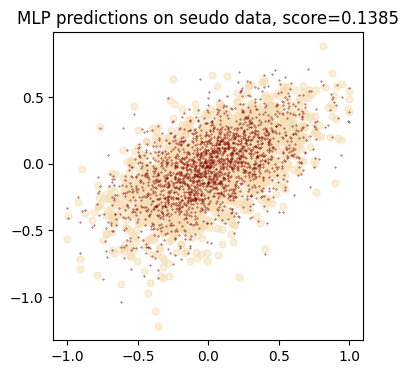

In [37]:
plt.scatter(X_test[:,0], y_test, c='wheat', alpha=0.5)
plt.scatter(X_test[:,0], y_pred, s=0.1, c='maroon', alpha=1)
plt.title(f"MLP predictions on seudo data, score={score:.4f}")
plt.show()

In [38]:
X_train.shape

(8000, 210)

# Iterative Method

In [39]:
iter_num_noises = [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
iter_inds = []

In [40]:
for num_noises in iter_num_noises:
    reduce_rate = 0.8
    best_score = 10
    num_cur_features = num_features+num_noises

    X, y_true, y_noise, intercepts, derivatives, integrations = \
    create_simulation_data(function, num_features, num_noises, num_data, X_var, y_var, n_steps=n_steps)
    print('X', X.shape, 'y true', y_true.shape, 'y noise', y_noise.shape, 
          'intercepts', len(intercepts), intercepts[0].shape,
          'derivatives', len(derivatives), derivatives[0].shape, 
          'integrations', len(integrations), integrations[0].shape)

    intercepts = np.stack(intercepts, axis=1)
    derivatives = np.stack(derivatives, axis=1)
    integrations = np.stack(integrations, axis=1)
    y = y_true + y_noise

    X_train, X_test, \
    y_train, y_test, \
    y_true_train, y_true_test, \
    intercepts_train, intercepts_test, \
    derivatives_train, derivatives_test, \
    integrations_train, integrations_test \
    = train_test_split(X, y, y_true, intercepts, derivatives, integrations, test_size=test_size, random_state=seed)

    train_set = TensorDataset(Tensor(X_train), Tensor(y_train))
    train_loader = DataLoader(train_set, batch_size=y_train.shape[0], shuffle=True)
    test_set = TensorDataset(Tensor(X_test), Tensor(y_true_test))
    test_loader = DataLoader(test_set, batch_size=y_test.shape[0])

    model = MLPRegressor(num_cur_features, hidden_layer_sizes, p=0.0)
    model.to(device)
    model.train()

    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), 0.001)
    train(model, train_loader, num_epochs, optimizer)

    model.eval()
    y_pred = model(Tensor(X_test).to(device)).detach().cpu().numpy()

    xai = Saliency(model)
    # xai = DeepLift(model)
    # xai = FeatureAblation(model)
    # xai = IntegratedGradients(model)

    xai_attr_test = xai.attribute(Tensor(X_test).to(device))
    abs_xai_attr_test = np.abs(xai_attr_test.detach().cpu().numpy()).mean(0)
    inds = np.argpartition(-abs_xai_attr_test, num_features-1)[:num_features]
    iter_inds.append(inds)

X (10000, 10) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.0002424947451800108
X (10000, 30) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)


/home/geshi/captum/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


train loss: 0.0004070638387929648
X (10000, 50) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.0003766559821087867
X (10000, 70) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.001072294544428587
X (10000, 90) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.0005715130246244371
X (10000, 110) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.00030578943551518023
X (10000, 130) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 0.00012598681496456265
X (10000, 150) y true (10000, 1) y noise (10000, 1) intercepts 10 (10000,) derivatives 10 (10000,) integrations 10 (10000,)
train loss: 2.319844497833401e-05
X (10000, 170) y tru

In [43]:
iter_inds

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([8, 1, 2, 3, 4, 0, 6, 7, 5, 9]),
 array([ 8,  1,  2,  3,  4,  0,  6,  7,  9, 48]),
 array([ 6,  0,  2,  3,  1,  4,  7,  9, 55,  8]),
 array([ 8,  0,  2,  3,  4,  1,  6,  7,  9, 59]),
 array([ 9,  8,  2,  3,  4,  1,  6,  7,  0, 17]),
 array([ 0,  6,  2,  1,  7,  4,  3, 72, 86, 67]),
 array([  1,   0,   2,   3,   4,   7,   6,  37,   8, 134]),
 array([  1,   0,   2,   3,   6,   4,   7, 144,  88, 137]),
 array([149,   6,   2,   3,   4,   0,   1,   7,  95,  41]),
 array([ 6,  1,  2,  3,  4,  0,  7, 97, 25, 98])]